<a href="https://colab.research.google.com/github/MateoPeri/steel-scrap-predictor/blob/master/Steel%20Scrap%20Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import glob, os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import altair as alt
plt.style.use('seaborn-poster')

# Data preparation

In [62]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
!unzip {PATH}raw.zip -d {PATH}

--2020-06-13 17:27:51--  https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2547005 (2.4M) [application/zip]
Saving to: ‘/content/data/raw.zip’

raw.zip             100%[===================>]   2.43M  10.5MB/s    in 0.2s    

2020-06-13 17:27:51 (10.5 MB/s) - ‘/content/data/raw.zip’ saved [2547005/2547005]

Archive:  /content/data/raw.zip
   creating: /content/data/raw/
  inflating: /content/data/raw/CSF EOI.xlsx  
  inflating: /content/data/raw/CSF TV.xlsx  
  inflating: /content/data/raw/HC Closing Prices.xlsx  
  inflating: /content/data/raw/HC Final Settlement prices.xlsx  
  inflating: /content/data/raw/HU Closing Prices.xlsx  
  inflating: /content/data/raw/HU Final Settlemen

## Load dataset

In [0]:
def st_to_mt(st):
  return st/1.10231131

In [64]:
p = PATH+'raw/*Closing Prices.xlsx'
excels = glob.glob(p)

frames = []
to_keep = 'M1'

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  # le añadimos un nombre para saber qué metal es
  name = os.path.basename(xcel)[:2]
  if name == 'HU':
    # Seleccionar todas las columnas menos USD/st
    cols = [c for c in d.columns if c != 'USD/st (Short Ton)']
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    d[cols] = d[cols].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    d.rename({'USD/st (Short Ton)': 'USD/mt'}, axis=1, inplace=True)
  
  d.columns = ['Date'] + [name+'_'+c for c in d.columns if c != 'USD/mt']
  
  frames.append(d)

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames]
df = pd.concat(dfs, axis=1)

df.head()

,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,HU_M1,HU_M2,HU_M3,HU_M4,HU_M5,HU_M6,HU_M7,HU_M8,HU_M9,HU_M10,HU_M11,HU_M12,HU_M13,HU_M14,HU_M15,HC_M1,HC_M2,HC_M3,HC_M4,HC_M5,HC_M6,HC_M7,HC_M8,HC_M9,HC_M10,HC_M11,HC_M12,HC_M13,HC_M14,HC_M15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-11-23,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,338.0,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-24,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,337.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-25,195.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-26,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-27,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
p = PATH+'raw/CSF*.xlsx'

excels = glob.glob(p)

frames = []

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  name = os.path.basename(xcel)[-8:5].strip()
  print(d.dtypes)
  print(d.head())
  d[['HU']] = d[['HU']].apply(st_to_mt, axis=1)
  # Cambiamos el nombre a la columna
  d.rename(dict(zip(cols, [name+'_'+c for c in d.columns])), axis=1, inplace=True)
  
  d.columns = ['Date'] + [name+'_'+c for c in d.columns if c != 'USD/mt']
  frames.append(d)

dfs = [df] + [d.drop_duplicates().set_index(['Date']) for d in frames]
df = pd.concat(dfs, axis=1)

df.head()



Date    datetime64[ns]
SC             float64
SR             float64
HC              object
HU              object
AM              object
UP              object
dtype: object
        Date      SC     SR    HC    HU    AM    UP
0 2017-01-03     NaN   34.0  n.a.  n.a.  n.a.  n.a.
1 2017-01-04   172.0  144.0  n.a.  n.a.  n.a.  n.a.
2 2017-01-05   954.0  174.0  n.a.  n.a.  n.a.  n.a.
3 2017-01-06  1038.0  123.0  n.a.  n.a.  n.a.  n.a.
4 2017-01-09   708.0   57.0  n.a.  n.a.  n.a.  n.a.


TypeError: ignored

In [12]:
# Cuando empiezan los valores de HU y HC -> 2019-03-11
df = df.dropna()
df.index[0]

Timestamp('2019-03-11 00:00:00')

In [31]:
# Contamos los valores nulos del dataset -> 0
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2019-03-11 to 2020-05-05
Data columns (total 60 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SC_M1   292 non-null    float64
 1   SC_M2   292 non-null    float64
 2   SC_M3   292 non-null    float64
 3   SC_M4   292 non-null    float64
 4   SC_M5   292 non-null    float64
 5   SC_M6   292 non-null    float64
 6   SC_M7   292 non-null    float64
 7   SC_M8   292 non-null    float64
 8   SC_M9   292 non-null    float64
 9   SC_M10  292 non-null    float64
 10  SC_M11  292 non-null    float64
 11  SC_M12  292 non-null    float64
 12  SC_M13  292 non-null    float64
 13  SC_M14  292 non-null    float64
 14  SC_M15  292 non-null    float64
 15  SR_M1   292 non-null    float64
 16  SR_M2   292 non-null    float64
 17  SR_M3   292 non-null    float64
 18  SR_M4   292 non-null    float64
 19  SR_M5   292 non-null    float64
 20  SR_M6   292 non-null    float64
 21  SR_M7   292 non-null

# Data visualization

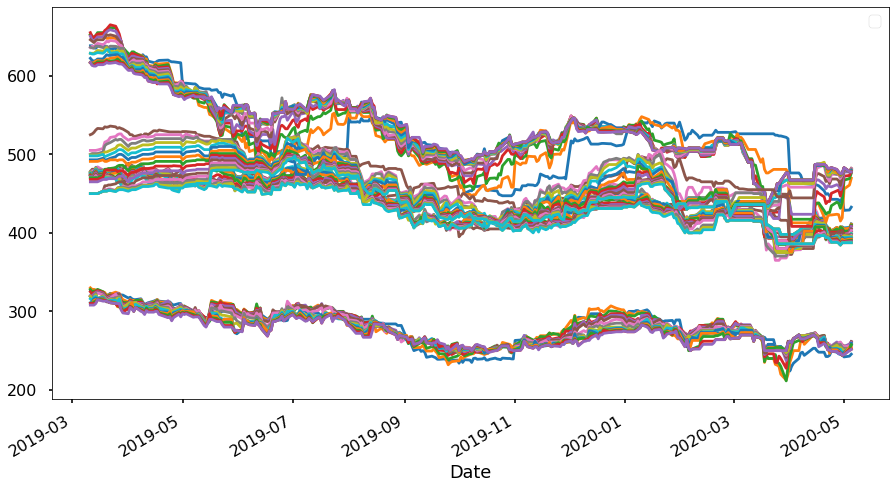

In [32]:
fig, ax = subplots()
df.plot(figsize=(15,8), ax=ax)
ax.legend([]);

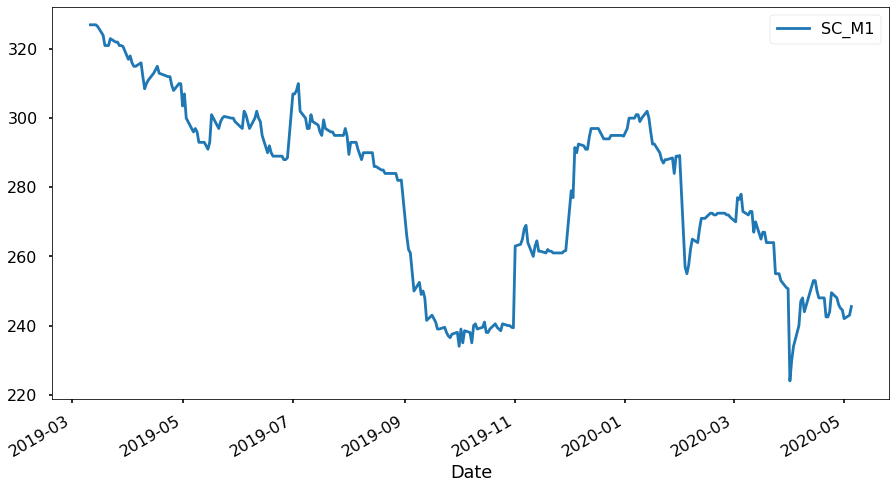

In [33]:
df[['SC_M1']].plot(figsize=(15,8))

# Model

In [0]:
to_predict = 'SC_M1'
data = df.reset_index().copy()
data = data[['Date', to_predict]]

In [0]:
def add_caps(d1, d2=None, c='y'):
  if d2 is None:
    d2 = d1
  d2['cap'] = d1[c].max()
  d2['floor'] = d1[c].min()
  return d2

In [28]:
print(df[[c for c in df.columns if c not in ['Date', to_predict]]].head())

            SC_M2  SC_M3  SC_M4  SC_M5  ...  HC_M12  HC_M13  HC_M14  HC_M15
Date                                    ...                                
2015-11-23  195.0  195.0  195.0  195.0  ...     NaN     NaN     NaN     NaN
2015-11-24  195.0  195.0  195.0  195.0  ...     NaN     NaN     NaN     NaN
2015-11-25  193.0  193.0  193.0  193.0  ...     NaN     NaN     NaN     NaN
2015-11-26  193.0  193.0  193.0  193.0  ...     NaN     NaN     NaN     NaN
2015-11-27  193.0  193.0  193.0  193.0  ...     NaN     NaN     NaN     NaN

[5 rows x 59 columns]


In [0]:
def generate_model(dff):
  fecha = '2019-03-11'

  others = [c for c in dff.columns if c not in ['Date', to_predict]] #dff[[c for c in df.columns if c not in ['Date', to_predict]]].columns
  dff.rename({'Date': 'ds', to_predict: 'y'}, axis=1, inplace=True)
  #dff = dff[['ds', 'y']]

  dff = dff.loc[dff.ds > fecha].copy()
  dff = add_caps(dff)
  modelo_futuro = Prophet(growth='linear', seasonality_mode='additive', yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)
  for o in others:
    modelo_futuro.add_regressor(o)
  print('Added', len(others), 'regressors')
  return modelo_futuro, dff

In [43]:
model, df_pred = generate_model(data)
df_pred.head()

Added 0 regressors


,ds,y,cap,floor
834,2019-03-12,327.0,327.0,224.0
835,2019-03-13,327.0,327.0,224.0
836,2019-03-14,327.0,327.0,224.0
837,2019-03-15,326.5,327.0,224.0
838,2019-03-18,324.0,327.0,224.0


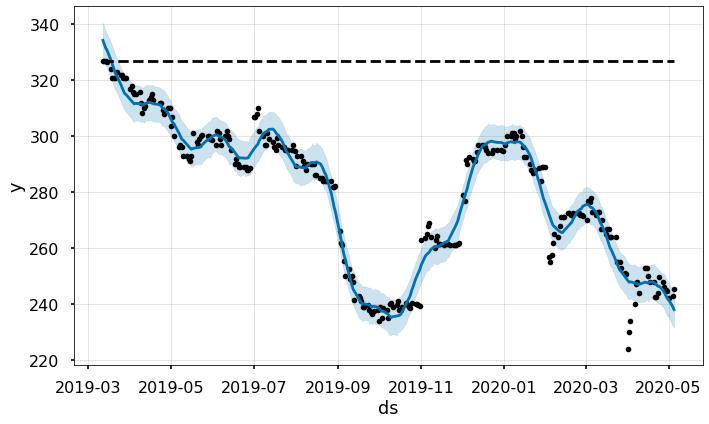

In [44]:
model.fit(df_pred)
forecast = model.predict(df_pred)
fig = model.plot(forecast)

In [45]:
forecast['fact'] = df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(forecast.fact, forecast.yhat)*100))

Accuracy: 96.35%


# Predict Future [EN PROCESO]

In [0]:
# 3 more months from end of data
future = model.make_future_dataframe(periods=730, freq='d')
future = add_caps(df_pred, future)

In [0]:
# 

In [70]:
future_forecast = model.predict(future)
fig = model.plot(future_forecast)

ValueError: ignored

In [51]:
future_forecast['fact'] = future['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(future_forecast.fact, future_forecast.yhat)*100))

Accuracy: 99.05%
